In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import sys
import os
import neo4j
from IPython.display import display
import psycopg2

# Raw Data Pull from Github


|variable          |class     |description       |
|:-----------------|:---------|:-----------------|
|year              |double    |The year.              |
|coo_name          |character |Country of origin name.        |
|coo               |character |Country of origin UNHCR code.   |
|coo_iso           |character |Country of origin ISO code.  |
|coa_name          |character |Country of asylum name.    |
|coa               |character |Country of asylum UNHCR code.  |
|coa_iso           |character |Country of asylum ISO code.    |
|refugees          |double    |The number of refugees.   |
|asylum_seekers    |double    |The number of asylum-seekers.  |
|returned_refugees |double    |The number of returned refugees. |
|idps              |double    |The number of internally displaced persons.     |
|returned_idps     |double    |The number of returned internally displaced persons.  |
|stateless         |double    |The number of stateless persons.  |
|ooc               |double    |The number of others of concern to UNHCR.   |
|oip               |double    |The number of other people in need of international protection.     |
|hst               |double    |The number of host community members.     |

In [ ]:
#Load the data, CSV file format
population = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-22/population.csv')

# Data Exploration

In [ ]:
#Initial data exploration
population.head()

,year,coo_name,coo,coo_iso,coa_name,coa,coa_iso,refugees,asylum_seekers,returned_refugees,idps,returned_idps,stateless,ooc,oip,hst
0,2010,Afghanistan,AFG,AFG,Afghanistan,AFG,AFG,0,0,0,351907,3366,0,838250,NaN,NaN
1,2010,Iran (Islamic Rep. of),IRN,IRN,Afghanistan,AFG,AFG,30,21,0,0,0,0,0,NaN,NaN
2,2010,Iraq,IRQ,IRQ,Afghanistan,AFG,AFG,6,0,0,0,0,0,0,NaN,NaN
3,2010,Pakistan,PAK,PAK,Afghanistan,AFG,AFG,6398,9,0,0,0,0,0,NaN,NaN
4,2010,Egypt,ARE,EGY,Albania,ALB,ALB,5,0,0,0,0,0,0,NaN,NaN


In [ ]:
#Initial data exploration
population.describe()

,year,refugees,asylum_seekers,returned_refugees,idps,returned_idps,stateless,ooc,oip,hst
count,64809.000000,6.480900e+04,64809.000000,64809.000000,6.480900e+04,6.480900e+04,64809.000000,6.480900e+04,1.000000e+02,5.964000e+03
mean,2016.393356,3.440013e+03,564.166119,73.480659,7.088696e+03,7.061573e+02,756.625191,4.374958e+02,1.966112e+05,6.264660e+03
std,3.722613,5.525597e+04,7455.730894,2460.282939,1.631746e+05,2.365424e+04,19980.220686,2.018268e+04,4.195870e+05,2.100905e+05
min,2010.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,5.000000e+00,0.000000e+00
25%,2013.000000,5.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.218250e+03,0.000000e+00
50%,2017.000000,1.200000e+01,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.316500e+04,0.000000e+00
75%,2020.000000,8.800000e+01,57.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.647600e+05,0.000000e+00
max,2022.000000,3.737369e+06,940668.000000,381275.000000,8.252788e+06,2.134349e+06,955399.000000,3.206577e+06,2.453862e+06,1.520972e+07


In [ ]:
#Count the number of nulls in each column
population.isnull().sum()
#Overall, pretty clean data! No nulls in the columns relevant to us

year                     0
coo_name                 0
coo                      0
coo_iso                  0
coa_name                 0
coa                      0
coa_iso                  0
refugees                 0
asylum_seekers           0
returned_refugees        0
idps                     0
returned_idps            0
stateless                0
ooc                      0
oip                  64709
hst                  58845
dtype: int64

In [ ]:
#Number of rows--in other words, number of unique coo-coa connections
len(population)

64809

In [ ]:
#Range of Dates through which Refugees Were Tracked

min_date = population['year'].min()
max_date = population['year'].max()

print(f"Date range: {min_date} to {max_date}")

Date range: 2010 to 2022


In [ ]:
#Find Unique Values in the Column "Country of Origin"

population['coo_name'].unique()

array(['Afghanistan', 'Iran (Islamic Rep. of)', 'Iraq', 'Pakistan',
       'Egypt', 'China', 'Palestinian',
       'Serbia and Kosovo: S/RES/1244 (1999)', 'Türkiye', 'Angola',
       'Benin', 'Chad', 'Cameroon', 'Congo', 'Dem. Rep. of the Congo',
       'Guinea', "Cote d'Ivoire", 'Liberia', 'Libya', 'Niger', 'Nigeria',
       'Somalia', 'Sudan', 'Western Sahara', 'Burundi',
       'Central African Rep.', 'Eritrea', 'Ethiopia', 'Guinea-Bissau',
       'Mauritania', 'Rwanda', 'Senegal', 'Sierra Leone',
       'United Rep. of Tanzania', 'Unknown', 'Algeria', 'Djibouti',
       'Kazakhstan', 'Mali', 'Russian Federation', 'Saudi Arabia',
       'Syrian Arab Rep.', 'Tajikistan', 'Turkmenistan', 'Tunisia',
       'Uganda', 'Uzbekistan', 'Yemen', 'Zimbabwe', 'Stateless',
       'Albania', 'Armenia', 'Bangladesh',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominican Rep.',
       'Ecuador', 'Georgia', 'Ghana', 'Haiti',

In [ ]:
#Find Unique Values in the Column "Country of Asylum"

population['coa_name'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Egypt',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Bahrain', 'Burundi', 'Belgium', 'Benin', 'Bangladesh', 'Bahamas',
       'Burkina Faso', 'Belarus', 'Bolivia (Plurinational State of)',
       'Botswana', 'Brazil', 'Brunei Darussalam',
       'Bosnia and Herzegovina', 'Bulgaria', 'Belize', 'Cambodia',
       'Canada', 'Central African Rep.', 'Cayman Islands', 'Chad',
       'China', 'Chile', 'Cameroon', 'Congo', 'Dem. Rep. of the Congo',
       'Colombia', 'Costa Rica', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Rep.', 'Ecuador', 'Eritrea', 'Estonia',
       'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia',
       'United Kingdom of Great Britain and Northern Ireland', 'Georgia',
       'Germany', 'Ghana', 'Guinea-Bissau', 'Greece', 'Grenada',
       'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'China, Hong Kong SAR',
       'Honduras', 'Croatia', 'Hungary', 'Icel

In [ ]:
#Find total number of origin and asylum countries and number of unique countries

country_list = list(population['coo_name'].unique())
print(f'Number of origin countries: {len(country_list)}')
country_list.extend(population['coa_name'].unique())
print(f'Number of asylum countries: {len(population["coa_name"].unique())}')
country_list = list(set(country_list))
print(f'Total number of unique countries: {len(country_list)}')

Number of origin countries: 210
Number of asylum countries: 189
Total number of unique countries: 212


In [ ]:
#Check for non-numeric values in the numeric columns that are relevant to our analysis

non_numeric_rows = pd.DataFrame()

for col in ['refugees', 'asylum_seekers']:
    mask = pd.to_numeric(population[col], errors='coerce').isna()
    non_numeric_rows[col] = mask

#Seems that there are no non-numeric values in these columns

In [ ]:
#Drop rows where country of asylum and country of origin are the same, since we are only interested in movement
#between countries


population = population[population['coo_name'] != population['coa_name']].reset_index()
population.head()

,index,year,coo_name,coo,coo_iso,coa_name,coa,coa_iso,refugees,asylum_seekers,returned_refugees,idps,returned_idps,stateless,ooc,oip,hst
0,1,2010,Iran (Islamic Rep. of),IRN,IRN,Afghanistan,AFG,AFG,30,21,0,0,0,0,0,NaN,NaN
1,2,2010,Iraq,IRQ,IRQ,Afghanistan,AFG,AFG,6,0,0,0,0,0,0,NaN,NaN
2,3,2010,Pakistan,PAK,PAK,Afghanistan,AFG,AFG,6398,9,0,0,0,0,0,NaN,NaN
3,4,2010,Egypt,ARE,EGY,Albania,ALB,ALB,5,0,0,0,0,0,0,NaN,NaN
4,5,2010,China,CHI,CHN,Albania,ALB,ALB,6,0,0,0,0,0,0,NaN,NaN


In [ ]:
#Sum "Refugees" and "Asylum Seekers" Columns to Get Total Number of Refugees
population['total_refugees'] = population['refugees'] + population['asylum_seekers']
population.head()

,index,year,coo_name,coo,coo_iso,coa_name,coa,coa_iso,refugees,asylum_seekers,returned_refugees,idps,returned_idps,stateless,ooc,oip,hst,total_refugees
0,1,2010,Iran (Islamic Rep. of),IRN,IRN,Afghanistan,AFG,AFG,30,21,0,0,0,0,0,NaN,NaN,51
1,2,2010,Iraq,IRQ,IRQ,Afghanistan,AFG,AFG,6,0,0,0,0,0,0,NaN,NaN,6
2,3,2010,Pakistan,PAK,PAK,Afghanistan,AFG,AFG,6398,9,0,0,0,0,0,NaN,NaN,6407
3,4,2010,Egypt,ARE,EGY,Albania,ALB,ALB,5,0,0,0,0,0,0,NaN,NaN,5
4,5,2010,China,CHI,CHN,Albania,ALB,ALB,6,0,0,0,0,0,0,NaN,NaN,6


/tmp/ipykernel_24/4038820459.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks()])


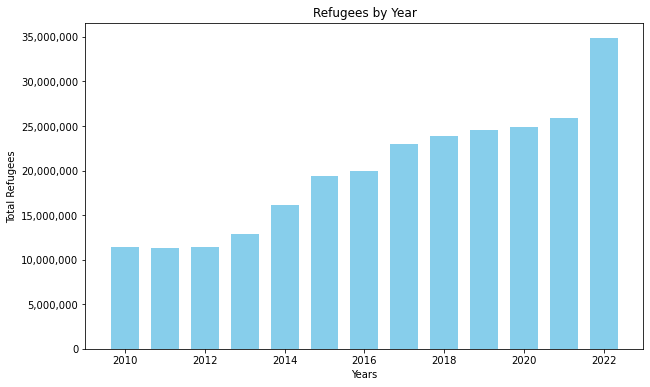

In [ ]:
# Visualize the number of refugees each year'
r_table = pd.pivot_table(population, values='total_refugees', index=['year'], aggfunc="sum")
r_table.reset_index(inplace=True)
# Create the bar chart
# plt.figure(figsize=(20, 20))
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(r_table['year'], r_table['total_refugees'], color='skyblue', width=0.7)

# Add labels and title
plt.xlabel('Years')
plt.ylabel('Total Refugees')
plt.title('Refugees by Year')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks()])

# Display the chart
plt.show()

/tmp/ipykernel_24/3601204363.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks()])


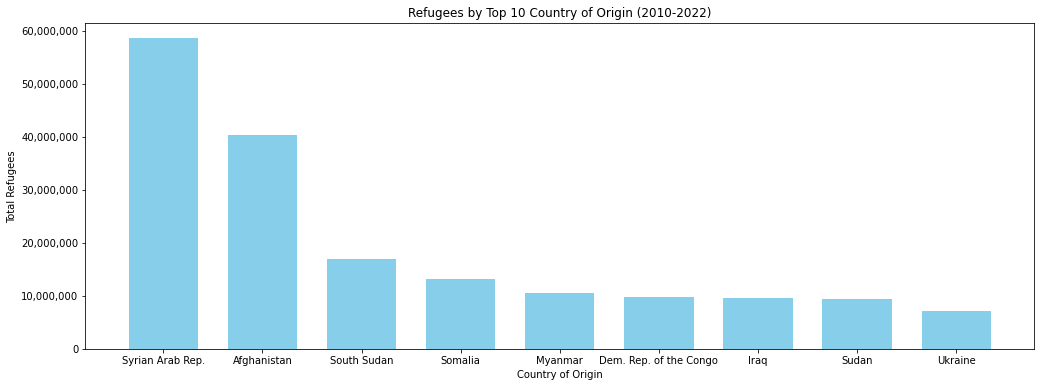

In [ ]:
# Visualize the number of refugees for the top 10 countries of Origin (2010-2022)
o_table = pd.pivot_table(population, values='total_refugees', index=['coo_name'], aggfunc="sum").sort_values(by=['total_refugees'],ascending=False)
o_table.reset_index(inplace=True)
o_table
# Create the bar chart
# plt.figure(figsize=(20, 20))
fig, ax = plt.subplots(figsize=(17, 6))
bars = ax.bar(o_table['coo_name'][0:9], o_table['total_refugees'][0:9], color='skyblue', width=0.7)

# Add labels and title
plt.xlabel('Country of Origin')
plt.ylabel('Total Refugees')
plt.title('Refugees by Top 10 Country of Origin (2010-2022)')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks()])

# Display the chart
plt.show()

In [ ]:
#Display in Table Format

# Get the top 10 countries by total refugees
top_10_table = o_table.head(10).copy()

# Optionally format numbers with commas for readability
top_10_table['total_refugees'] = top_10_table['total_refugees'].apply(lambda x: f"{int(x):,}")

# Display the table
top_10_table


,coo_name,total_refugees
0,Syrian Arab Rep.,"58,610,385"
1,Afghanistan,"40,246,709"
2,South Sudan,"16,942,541"
3,Somalia,"13,191,897"
4,Myanmar,"10,585,463"
5,Dem. Rep. of the Congo,"9,686,633"
6,Iraq,"9,575,274"
7,Sudan,"9,310,700"
8,Ukraine,"7,164,542"
9,Central African Rep.,"6,130,348"


# Connect to Neo4j

In [ ]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j", "ucb_mids_w205"))
session = driver.session(database="neo4j")

# Set up Functions

In [ ]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"

    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)

    query = "match (node) delete node"
    session.run(query)

In [ ]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"

    result = session.run(query, **kwargs)

    df = pd.DataFrame([r.values() for r in result], columns=result.keys())

    return df

In [ ]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"

    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")

    query = """
        match (n)
        return n.name as node_name, labels(n) as labels
        order by n.name
    """

    df = my_neo4j_run_query_pandas(query)

    number_nodes = df.shape[0]

    display(df)

    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")

    query = """
        match (n1)-[r]->(n2)
        return n1.name as node_name_1, labels(n1) as node_1_labels,
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """

    df = my_neo4j_run_query_pandas(query)

    number_relationships = df.shape[0]

    display(df)

    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))

    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")

In [ ]:
def my_neo4j_create_node(country_name):
    "create a node with label Country Name"

    query = """

    CREATE (:Country {name: $country_name})

    """

    session.run(query, country_name=country_name)

In [ ]:
def my_neo4j_number_nodes_relationships():
    "print the number of nodes and relationships"


    query = """
        match (n)
        return n.name as node_name, labels(n) as labels
        order by n.name
    """

    df = my_neo4j_run_query_pandas(query)

    number_nodes = df.shape[0]


    query = """
        match (n1)-[r]->(n2)
        return n1.name as node_name_1, labels(n1) as node_1_labels,
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """

    df = my_neo4j_run_query_pandas(query)

    number_relationships = df.shape[0]

    print("-------------------------")
    print("  Nodes:", number_nodes)
    print("  Relationships:", number_relationships)
    print("-------------------------")

# Graph 1: Neo4j - Country of Origin to Country of Asylum (emigrating)

In [ ]:
my_neo4j_wipe_out_database()

In [ ]:
#Create Nodes for Each Country
for country in country_list:
    my_neo4j_create_node(country)

In [ ]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Afghanistan,[Country]
1,Albania,[Country]
2,Algeria,[Country]
3,Andorra,[Country]
4,Angola,[Country]
...,...,...
207,Viet Nam,[Country]
208,Western Sahara,[Country]
209,Yemen,[Country]
210,Zambia,[Country]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels


-------------------------
  Density: 0.0
-------------------------


In [ ]:
#No Relationships Yet, As Expected
my_neo4j_number_nodes_relationships()

#Number of Nodes Matches Country Count Above

-------------------------
  Nodes: 212
  Relationships: 0
-------------------------


In [ ]:
#Create one-way relationship from coo to coa

def my_neo4j_create_relationship_one_way(country_origin, country_asylum, weight, year):
    "create a relationship one way between two stations with a weight"

    query = """

    MATCH (from:Country),
          (to:Country)
    WHERE from.name = $country_origin and to.name = $country_asylum
    CREATE (from)-[:asylum {weight: $weight, year: $year}]->(to)

    """

    session.run(query, country_origin=country_origin, country_asylum=country_asylum, weight=weight, year=year)

In [ ]:
#Create Relationships between Nodes, One-Directional from Country of Origin to Country of Asylum
#With Weight as Total_Refugees (Refugees plus Asylum Seekers)
for row in range(len(population)):
    country_origin = population['coo_name'][row]
    country_asylum = population['coa_name'][row]
    total_refugees = population['total_refugees'][row]
    year = population['year'][row]


    my_neo4j_create_relationship_one_way(country_origin=country_origin, country_asylum=country_asylum, weight=total_refugees, year=year)

In [ ]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Afghanistan,[Country]
1,Albania,[Country]
2,Algeria,[Country]
3,Andorra,[Country]
4,Angola,[Country]
...,...,...
207,Viet Nam,[Country]
208,Western Sahara,[Country]
209,Yemen,[Country]
210,Zambia,[Country]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,Afghanistan,[Country],asylum,Albania,[Country]
1,Afghanistan,[Country],asylum,Albania,[Country]
2,Afghanistan,[Country],asylum,Albania,[Country]
3,Afghanistan,[Country],asylum,Algeria,[Country]
4,Afghanistan,[Country],asylum,Argentina,[Country]
...,...,...,...,...,...
64246,Zimbabwe,[Country],asylum,Zambia,[Country]
64247,Zimbabwe,[Country],asylum,Zambia,[Country]
64248,Zimbabwe,[Country],asylum,Zambia,[Country]
64249,Zimbabwe,[Country],asylum,Zambia,[Country]


-------------------------
  Density: 2.9
-------------------------


In [ ]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 212
  Relationships: 64251
-------------------------


In [ ]:
# Sanity Check: Print Emigration Relationships in Descending Order (Highest Number of Refugees Going from Country
#of Origin to Country of Asylum Appears First)

query = """
MATCH (n1:Country)-[r:asylum]->(n2:Country)
RETURN n1.name AS origin, n2.name AS asylum, r.weight AS total_refugees, r.year AS year
ORDER BY total_refugees DESC
LIMIT 10
"""
df = my_neo4j_run_query_pandas(query)
display(df)


,origin,asylum,total_refugees,year
0,Syrian Arab Rep.,Türkiye,3737369,2021
1,Syrian Arab Rep.,Türkiye,3641370,2020
2,Syrian Arab Rep.,Türkiye,3622477,2018
3,Syrian Arab Rep.,Türkiye,3576370,2019
4,Syrian Arab Rep.,Türkiye,3535898,2022
5,Syrian Arab Rep.,Türkiye,3424399,2017
6,Afghanistan,Iran (Islamic Rep. of),3413249,2022
7,Syrian Arab Rep.,Türkiye,2824167,2016
8,Syrian Arab Rep.,Türkiye,2503846,2015
9,Afghanistan,Pakistan,1901788,2010


In [ ]:
## Top countries by total refugees for Emigration

query = """
MATCH (n1:Country)-[r:asylum]->(n2:Country)
RETURN n1.name AS origin, sum(r.weight) AS total_refugees
ORDER BY total_refugees DESC
LIMIT 10
"""
df = my_neo4j_run_query_pandas(query)
display(df)

,origin,total_refugees
0,Syrian Arab Rep.,58610385
1,Afghanistan,40246709
2,South Sudan,16942541
3,Somalia,13191897
4,Myanmar,10585463
5,Dem. Rep. of the Congo,9686633
6,Iraq,9575274
7,Sudan,9310700
8,Ukraine,7164542
9,Central African Rep.,6130348


In [ ]:
## Check Yearly Trend

query = """
MATCH (o:Country)-[r:asylum]->(a:Country)
RETURN r.year AS year, sum(r.weight) AS total_refugees_that_year
ORDER BY year
"""
df = my_neo4j_run_query_pandas(query)
display(df)

,year,total_refugees_that_year
0,2010,11384794
1,2011,11299618
2,2012,11438475
3,2013,12861158
4,2014,16178993
5,2015,19333736
6,2016,19913807
7,2017,23030073
8,2018,23861182
9,2019,24562773


# Algorithms for Graph Depicting Emigration

## Algorithm # 1: Use PageRank to Find Most Influential Countries in Granting Asylum

In [ ]:
query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
session.run(query)

In [ ]:
query = "CALL gds.graph.project('ds_graph', 'Country', 'asylum', {relationshipProperties: 'weight'})"
session.run(query)

In [ ]:
query = """

CALL gds.pageRank.stream('ds_graph',
                         { maxIterations: $max_iterations,
                           dampingFactor: $damping_factor}
                         )
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as page_rank
ORDER BY page_rank DESC, name ASC

"""

max_iterations = 20
damping_factor = 0.05

my_neo4j_run_query_pandas(query, max_iterations=max_iterations, damping_factor=damping_factor)

,name,page_rank
0,United States of America,2.258903
1,Canada,1.879711
2,Germany,1.554083
3,Australia,1.552349
4,United Kingdom of Great Britain and Northern I...,1.474410
...,...,...
207,Stateless,0.950000
208,Tibetan,0.950000
209,Tonga,0.950000
210,Tuvalu,0.950000


## Algorithm # 2: Degree Centrality (Countries Most Involved in Refugee Movement)

In [ ]:
#Create Graph in Memory to Run Degree Centrality Algorithm
query = "CALL gds.graph.drop('refugee_graph', false) yield graphName"
session.run(query)

query = "CALL gds.graph.project('refugee_graph', 'Country', 'asylum', {relationshipProperties: 'total_refugees'})"
session.run(query)

In [ ]:
query = """
CALL gds.degree.stream('refugee_graph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS country, score
ORDER BY score DESC
LIMIT 10
"""
df = my_neo4j_run_query_pandas(query)
print("Degree Centrality (Most connected countries):")
display(df)

Degree Centrality (Most connected countries):


,country,score
0,Syrian Arab Rep.,1341.0
1,Somalia,1332.0
2,Iraq,1268.0
3,Dem. Rep. of the Congo,1256.0
4,Sudan,1215.0
5,Afghanistan,1141.0
6,Iran (Islamic Rep. of),1079.0
7,Eritrea,1077.0
8,Stateless,1075.0
9,Ethiopia,1056.0


## Algorithm 3: Betweenness Centrality (Countries that are Frequent Intermediaries)

In [ ]:
#Make weights the inverse of the original to give larger weights more influence in the all pairs shortest path
#calculation

query = """
MATCH ()-[r:asylum]->()
WHERE r.weight <> 0
SET r.inv_weight = 1.0 / r.weight
RETURN r.weight, r.inv_weight
LIMIT 10

"""

df = my_neo4j_run_query_pandas(query)
display(df)

,r.weight,r.inv_weight
0,8,0.125000
1,8,0.125000
2,12,0.083333
3,8,0.125000
4,5,0.200000
5,10,0.100000
6,10,0.100000
7,11,0.090909
8,5,0.200000
9,239,0.004184


In [ ]:
# Sanity Check to make sure weights were inverted

query = """
MATCH (n1:Country)-[r:asylum]->(n2:Country)
RETURN n1.name AS origin,
       n2.name AS asylum,
       r.weight AS total_refugees,
       r.inv_weight AS inv_weight,
       r.year AS year
ORDER BY total_refugees DESC
LIMIT 10
"""
df = my_neo4j_run_query_pandas(query)
display(df)




,origin,asylum,total_refugees,inv_weight,year
0,Syrian Arab Rep.,Türkiye,3737369,2.675679e-07,2021
1,Syrian Arab Rep.,Türkiye,3641370,2.746219e-07,2020
2,Syrian Arab Rep.,Türkiye,3622477,2.760542e-07,2018
3,Syrian Arab Rep.,Türkiye,3576370,2.796131e-07,2019
4,Syrian Arab Rep.,Türkiye,3535898,2.828136e-07,2022
5,Syrian Arab Rep.,Türkiye,3424399,2.920220e-07,2017
6,Afghanistan,Iran (Islamic Rep. of),3413249,2.929760e-07,2022
7,Syrian Arab Rep.,Türkiye,2824167,3.540867e-07,2016
8,Syrian Arab Rep.,Türkiye,2503846,3.993856e-07,2015
9,Afghanistan,Pakistan,1901788,5.258210e-07,2010


In [ ]:
#Create Graph in Memory to Run Betweenness Centrality Algorithm
# Drop the existing graph if it exists
query = "CALL gds.graph.drop('refugee_graph_inv', false) YIELD graphName"
session.run(query)

# Project a new graph using 'inv_weight' as the relationship weight
query = """
CALL gds.graph.project(
  'refugee_graph_inv',
  'Country',
  {
    asylum: {
      properties: ['inv_weight']
    }
  }
)
"""
session.run(query)


In [ ]:
#Run Betweenness Centrality Algorithm

query = """
CALL gds.betweenness.stream('refugee_graph_inv', {
  relationshipWeightProperty: 'inv_weight'
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS country, score
ORDER BY score DESC
LIMIT 10
"""
df = my_neo4j_run_query_pandas(query)
print("Betweenness Centrality (countries that are strong intermediaries):")
display(df)


Betweenness Centrality (countries that are strong intermediaries):


,country,score
0,Belgium,2.886156e+10
1,Iraq,2.874825e+10
2,Azerbaijan,2.851470e+10
3,Yemen,2.829025e+10
4,Somalia,2.822219e+10
5,Libya,2.763071e+10
6,Burundi,2.731731e+10
7,Kyrgyzstan,2.597380e+10
8,Tajikistan,2.577197e+10
9,Ethiopia,2.574963e+10


# Graph 2: Neo4j - Country of Asylum to Country of Origin (Immigrating)

In [ ]:
#Wipe out database to create new graph

my_neo4j_wipe_out_database()

In [ ]:
#Create Nodes for Each Country
for country in country_list:
    my_neo4j_create_node(country)

In [ ]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Afghanistan,[Country]
1,Albania,[Country]
2,Algeria,[Country]
3,Andorra,[Country]
4,Angola,[Country]
...,...,...
207,Viet Nam,[Country]
208,Western Sahara,[Country]
209,Yemen,[Country]
210,Zambia,[Country]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels


-------------------------
  Density: 0.0
-------------------------


In [ ]:
#No Relationships Yet, As Expected
my_neo4j_number_nodes_relationships()

#Number of Nodes Matches Country Count Above

-------------------------
  Nodes: 212
  Relationships: 0
-------------------------


In [ ]:
#Set up function

def my_neo4j_create_relationship_reverse(country_asylum, country_origin, weight, year):
    query = """
    MATCH (from:Country), (to:Country)
    WHERE from.name = $country_asylum AND to.name = $country_origin
    CREATE (from)-[:ORIGIN {weight: $weight, year: $year}]->(to)
    """
    session.run(query, country_asylum=country_asylum, country_origin=country_origin, weight=weight, year=year)

In [ ]:
#Create Relationships between Nodes, One-Directional from Country of Asylum to Country of Origin
#With Weight as Total_Refugees (Refugees plus Asylum Seekers)

for row in range(len(population)):
    country_asylum = population['coa_name'][row]
    country_origin = population['coo_name'][row]
    total_refugees = population['total_refugees'][row]
    year = population['year'][row]


    my_neo4j_create_relationship_reverse(country_asylum=country_asylum, country_origin=country_origin, weight=total_refugees, year=year)



In [ ]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Afghanistan,[Country]
1,Albania,[Country]
2,Algeria,[Country]
3,Andorra,[Country]
4,Angola,[Country]
...,...,...
207,Viet Nam,[Country]
208,Western Sahara,[Country]
209,Yemen,[Country]
210,Zambia,[Country]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,Afghanistan,[Country],ORIGIN,Bangladesh,[Country]
1,Afghanistan,[Country],ORIGIN,Bangladesh,[Country]
2,Afghanistan,[Country],ORIGIN,Bangladesh,[Country]
3,Afghanistan,[Country],ORIGIN,Benin,[Country]
4,Afghanistan,[Country],ORIGIN,Benin,[Country]
...,...,...,...,...,...
64246,Zimbabwe,[Country],ORIGIN,Zambia,[Country]
64247,Zimbabwe,[Country],ORIGIN,Zambia,[Country]
64248,Zimbabwe,[Country],ORIGIN,Zambia,[Country]
64249,Zimbabwe,[Country],ORIGIN,Zambia,[Country]


-------------------------
  Density: 2.9
-------------------------


In [ ]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 212
  Relationships: 64251
-------------------------


In [ ]:
## Top countries by total refugees (top countries in creating refugees)

query = """
MATCH (n1:Country)<-[r:ORIGIN]-(n2:Country)
RETURN n2.name AS asylum, sum(r.weight) AS total_refugees
ORDER BY total_refugees DESC
LIMIT 10
"""
df = my_neo4j_run_query_pandas(query)
display(df)

,asylum,total_refugees
0,Türkiye,32128422
1,Pakistan,20275909
2,Iran (Islamic Rep. of),14590778
3,Germany,14303740
4,United States of America,11197850
5,Uganda,11189323
6,Lebanon,9756462
7,Ethiopia,8492863
8,Jordan,8446359
9,Sudan,8116417


## Algorithm for Graph 2: Use PageRank to Find Most Influential Countries in Creating Refugees

In [ ]:
query = "CALL gds.graph.drop('ds_graph_2', false) yield graphName"
session.run(query)

In [ ]:
query = "CALL gds.graph.project('ds_graph_2', 'Country', 'ORIGIN', {relationshipProperties: 'weight'})"
session.run(query)

In [ ]:
query = """

CALL gds.pageRank.stream('ds_graph_2',
                         { maxIterations: $max_iterations,
                           dampingFactor: $damping_factor}
                         )
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as page_rank
ORDER BY page_rank DESC, name ASC

"""

max_iterations = 20
damping_factor = 0.05

my_neo4j_run_query_pandas(query, max_iterations=max_iterations, damping_factor=damping_factor)

,name,page_rank
0,Stateless,1.409711
1,Iraq,1.269865
2,Syrian Arab Rep.,1.266019
3,Venezuela (Bolivarian Republic of),1.245139
4,Sri Lanka,1.235741
...,...,...
207,Bermuda,0.950043
208,Micronesia (Federated States of),0.950042
209,Aruba,0.950021
210,Montserrat,0.950000
